<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/LC_FFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Add the KIC_first_100.csv to the runtime

In [2]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 247 kB 4.2 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
     |████████████████████████████████| 4.5 MB 57.2 MB/s 
     |████████████████████████████████| 41 kB 200 kB/s 
     |████████████████████████████████| 832 kB 42.2 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 4.1 MB 45.2 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11377 sha256=347ff239974927f76c1421ff598d08f3469a9e810e3567bc7447cb3ac830fdb7
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50469 sha256=19c83ee6936fc3312a6266d1648da9d5a2e9e297d902772370a0e407cef0a895
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995db

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy
from scipy.fft import fft, fftfreq
from scipy import signal
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
KOI_first_100 = pd.read_csv('KIC_first_100.csv')
KOI_first_100.drop(KOI_first_100.columns[0], axis=1, inplace=True)
KOI_first_100.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.120,0.140,0.00004,NaN,0.040,-0.070,0.080,-0.020,-0.080,0.080


#FFT

In [6]:
flux = []
time = []
for index, row in KOI_first_100.iterrows():
  search_result_q2 = lk.search_lightcurve('KIC ' + str(row['kepid']), author='Kepler', quarter=2)
  lc = search_result_q2.download()
  lc_flatten = lc.flatten()
  flux_small = lc_flatten['flux'].value
  time_small = lc_flatten['time'].value
  fluxi = np.arange(len(flux_small))
  mask = np.isfinite(flux_small)
  flux_filtered = np.interp(fluxi, fluxi[mask], flux_small[mask])
  sci_flux = abs(fft(flux_filtered))
  #sci_freq = scipy.fftpack.fftfreq(flux_small.size, time_small[1]-time_small[0])
  sci_freq = 0

  # getting the top 3 dominant frequencies
  f, Pxx = signal.periodogram(flux_filtered)
  top_3periods = {}

  top_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

  freqs = f[top_freq_indices]

  powers = Pxx[top_freq_indices]

  periods = 1 / np.array(freqs)

  top_3periods['period1'] = periods[0]
  top_3periods['freq1'] = freqs[0]
  top_3periods['power1'] = powers[0]

  top_3periods['period2'] = periods[1]
  top_3periods['freq2'] = freqs[1]
  top_3periods['power2'] = powers[1]

  top_3periods['period3'] = periods[2]
  top_3periods['freq3'] = freqs[2]
  top_3periods['power3'] = powers[2]

  # removing the sine waves of the dominant frequencies
  # use .max() for np array
  Fs = time_small.size
  sig1 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq1']*time_small)
  sig1_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq1']*time_small)
  sig2 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq2']*time_small)
  sig2_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq2']*time_small)
  sig3 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq3']*time_small)
  sig3_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq3']*time_small)

  flat_flux = np.abs(flux_filtered - sig1 - sig2 - sig3 - sig1_cos - sig2_cos - sig3_cos)

  flux.append(np.array(flat_flux))
  time.append(np.array(time_small))

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


In [7]:
flux = []
time = []
for index, row in KOI_first_100.iterrows():
  try:
    search_result_q2 = lk.search_lightcurve('KIC ' + str(row['kepid']), author='Kepler', quarter=2)
    lc = search_result_q2.download()
  except:
    pass
  lc_flatten = lc.flatten()
  flux_small = lc_flatten['flux'].value
  time_small = lc_flatten['time'].value
  fluxi = np.arange(len(flux_small))
  mask = np.isfinite(flux_small)
  flux_filtered = np.interp(fluxi, fluxi[mask], flux_small[mask])
  y = abs(flux_filtered)
  y[1] = 0
  fft_flux = np.real(y)
  flux.append(np.array(fft_flux))

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


In [17]:
from scipy.fft import fft, ifft
y = abs(fft(flux_filtered))
# find max freq and put it to 0
y[1] = 0
inv = np.real(ifft(y))
print(flux_filtered)
#assert ((flux_filtered - inv) < 1e-3).all()

[1.00118871 1.00123964 1.00072033 ... 1.00013975 0.99958144 0.99999832]


(0.0, 100.0)

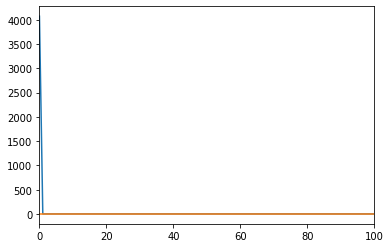

In [18]:
# try multilayer perceptron with abs(y) and y
plt.plot(np.real(y))
plt.plot(np.imag(y))
plt.xlim((0,100))

Text(0.5, 0, 'Time (JDays)')

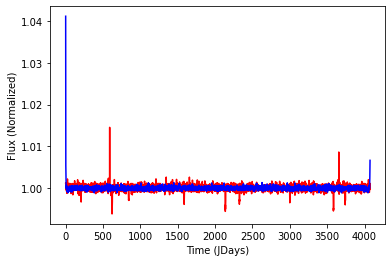

In [19]:
plt.plot(flux_filtered, c='r')
plt.plot(inv, c='b')
plt.ylabel('Flux (Normalized)')
plt.xlabel('Time (JDays)')

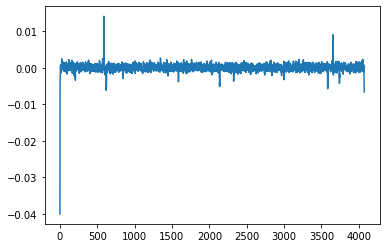

In [23]:
plt.plot(flux_filtered - inv)

In [24]:
sci_flux = fft(flux_filtered)
sci_freq = scipy.fftpack.fftfreq(flux_small.size, time_small[1]-time_small[0])
print(sci_freq)

[ 0.          0.01200915  0.0240183  ... -0.03602746 -0.0240183
 -0.01200915]


Text(0, 0.5, 'Flux (Normalized)')

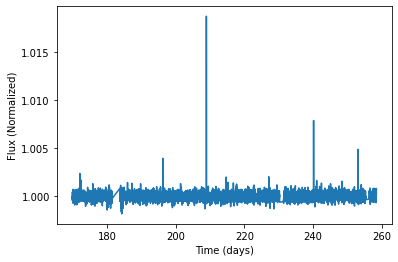

In [25]:
search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI_first_100['kepid'][0]), author='Kepler', quarter=2)
lc = search_result_q2.download()
lc_flatten = lc.flatten()
flux_small = lc_flatten['flux'].value
time_small = lc_flatten['time'].value

plt.plot(time_small, flux_small)
plt.xlabel('Time (days)')
plt.ylabel('Flux (Normalized)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Flux (Normalized)')

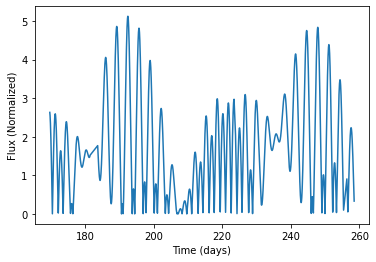

In [26]:
# One of the flux after removing dominant frequencies
flux = np.array(flux)
time = np.array(time)
plt.plot(time[20], flux[20])
plt.xlabel('Time (days)')
plt.ylabel('Flux (Normalized)')

In [27]:
df = {'Flux': flux,
      'Radius': KOI_first_100['koi_prad']}
df = pd.DataFrame(df)

## Having a problem splitting the DF for CNN training

In [28]:
X, y = df['Flux'], df['Radius']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train, X_test, y_train, y_test, X_val, y_val = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), np.array(X_val), np.array(y_val)

In [29]:
import tensorflow as tf
from tensorflow import keras
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean abs error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label='Val')
  plt.legend()
  plt.yliim([0, max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [1000$]')
  plt.ylabel('Predictions [1000$]')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100], [-100, 100])
  
  plt.figure()
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel('Prediction Error [1000$]')
  _ = plt.ylabel('Count')

In [30]:
def build_model():
  model = keras.Sequential([
      keras.layers.Input(shape=X_train.shape),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(1)
  ], name='MLP_model')

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', 
                optimizer=optimizer,
                metrics=['mae'])
  return model


model = build_model()
model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3904      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 500
# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=1)

ValueError: ignored